Saved raw synthetic series to synthetic_market.csv. Shape: (1500, 6)
Feature dataframe shape: (1485, 20)
Train rows: 1188, Test rows: 297


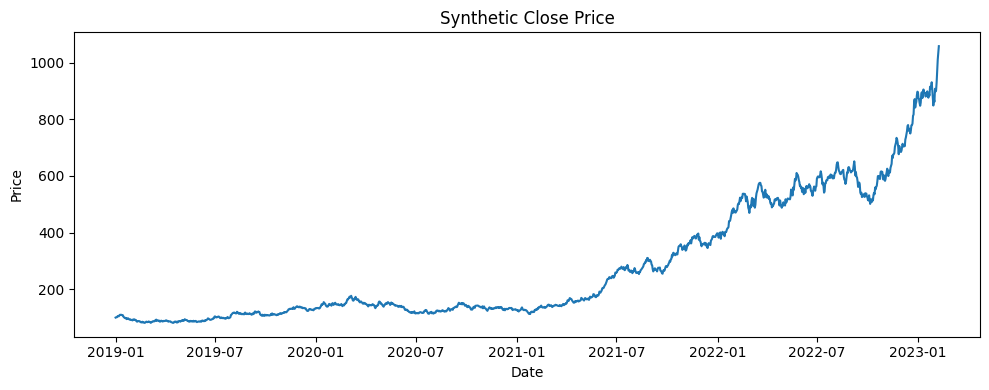

In [1]:
# Cell 1: Generate synthetic share market dataset, preprocess, and split
import os
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Config / seed
np.random.seed(42)
CSV_PATH = "synthetic_market.csv"
TRAIN_CSV = "market_train.csv"
TEST_CSV = "market_test.csv"

def generate_geometric_brownian(start_price=100.0, mu=0.0005, sigma=0.01, days=1500):
    """
    Generate a simple GBM price series (daily) with volume.
    mu: drift per day
    sigma: volatility per day
    """
    dt = 1.0
    prices = [start_price]
    for _ in range(days-1):
        prev = prices[-1]
        shock = np.random.normal(loc=(mu*dt), scale=(sigma*np.sqrt(dt)))
        new = prev * np.exp(shock)
        prices.append(new)
    return np.array(prices)

# Generate dates and series
days = 1500  # ~6 years of trading days (including weekends; synthetic)
start_date = pd.to_datetime("2019-01-01")
dates = pd.date_range(start_date, periods=days, freq="D")  # daily synthetic
close_prices = generate_geometric_brownian(start_price=100.0, mu=0.0006, sigma=0.02, days=days)

# Construct open/high/low from close with small random spreads, and volume
opens = close_prices * (1 + np.random.normal(0, 0.0015, size=days))
highs = np.maximum(opens, close_prices) * (1 + np.abs(np.random.normal(0, 0.005, size=days)))
lows = np.minimum(opens, close_prices) * (1 - np.abs(np.random.normal(0, 0.005, size=days)))
volumes = np.random.randint(100000, 2000000, size=days)

df = pd.DataFrame({
    "date": dates,
    "open": opens,
    "high": highs,
    "low": lows,
    "close": close_prices,
    "volume": volumes
})
df = df.sort_values("date").reset_index(drop=True)

# Save raw CSV
df.to_csv(CSV_PATH, index=False)
print(f"Saved raw synthetic series to {CSV_PATH}. Shape: {df.shape}")

# Preprocessing into supervised features
def make_features(df, lags=[1,2,3,5,7], rolling_windows=[3,7,14]):
    df_feat = df.copy()
    df_feat = df_feat.set_index("date")
    for lag in lags:
        df_feat[f"lag_{lag}"] = df_feat["close"].shift(lag)
    for w in rolling_windows:
        df_feat[f"roll_mean_{w}"] = df_feat["close"].rolling(window=w).mean().shift(1)
        df_feat[f"roll_std_{w}"] = df_feat["close"].rolling(window=w).std().shift(1)
    # Momentum / pct change features
    df_feat["pct_change_1"] = df_feat["close"].pct_change().shift(1)
    df_feat["vol_ma_7"] = df_feat["volume"].rolling(window=7).mean().shift(1)
    # target: next-day close
    df_feat["target_close"] = df_feat["close"].shift(-1)
    df_feat = df_feat.dropna().reset_index()
    return df_feat

df_feat = make_features(df)
print("Feature dataframe shape:", df_feat.shape)
df_feat.head()
# Save processed dataset (optional)
df_feat.to_csv("synthetic_market_features.csv", index=False)

# Time-based train/test split (last 20% as test)
split_index = int(len(df_feat) * 0.8)
train_df = df_feat.iloc[:split_index].reset_index(drop=True)
test_df = df_feat.iloc[split_index:].reset_index(drop=True)

train_df.to_csv(TRAIN_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)
print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")

# Quick plot of the close prices
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['close'], label="Close")
plt.title("Synthetic Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


In [2]:
# Cell 2: Train a RandomForestRegressor model and save model + artifacts
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Import numpy for square root
import numpy as np 
# The original code was missing 'import pandas as pd' but it is implied by usage
import pandas as pd

# Paths to save
MODEL_PATH = "rf_close_model.pkl"
SCALER_PATH = "scaler.pkl"
ARTIFACT_PATH = "model_artifacts.pkl"  # will store feature list and last known data for forecasting

# Load processed train/test
train_df = pd.read_csv("market_train.csv")
test_df = pd.read_csv("market_test.csv")

# Define features
feature_cols = [c for c in train_df.columns if c not in ["date", "target_close"]]

print("Features used:", feature_cols)

# Scale numeric features (volume might be large)
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
y_train = train_df["target_close"].values
X_test = scaler.transform(test_df[feature_cols])
y_test = test_df["target_close"].values

# Train model
model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

# --- CORRECTED LINE FOR RMSE CALCULATION ---
# Calculate MSE first, then take the square root to get RMSE.
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse) 
# --- END CORRECTION ---

print(f"Test MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Save artifacts
joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
# Save feature list and full original df (to know last observed window for iterative forecast)
artifacts = {
    "feature_columns": feature_cols,
    "full_raw_csv": "synthetic_market.csv",  # file we generated earlier
    "processed_features_csv": "synthetic_market_features.csv"
}
joblib.dump(artifacts, ARTIFACT_PATH)

print(f"Saved model to {MODEL_PATH}, scaler to {SCALER_PATH}, artifacts to {ARTIFACT_PATH}")

Features used: ['open', 'high', 'low', 'close', 'volume', 'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'roll_mean_3', 'roll_std_3', 'roll_mean_7', 'roll_std_7', 'roll_mean_14', 'roll_std_14', 'pct_change_1', 'vol_ma_7']


Test MAE: 94.1078, RMSE: 150.5061
Saved model to rf_close_model.pkl, scaler to scaler.pkl, artifacts to model_artifacts.pkl


Features used: ['open', 'high', 'low', 'close', 'volume', 'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'roll_mean_3', 'roll_std_3', 'roll_mean_7', 'roll_std_7', 'roll_mean_14', 'roll_std_14', 'pct_change_1', 'vol_ma_7']


Test MAE: 94.1078, RMSE: 150.5061, R²: -0.3978


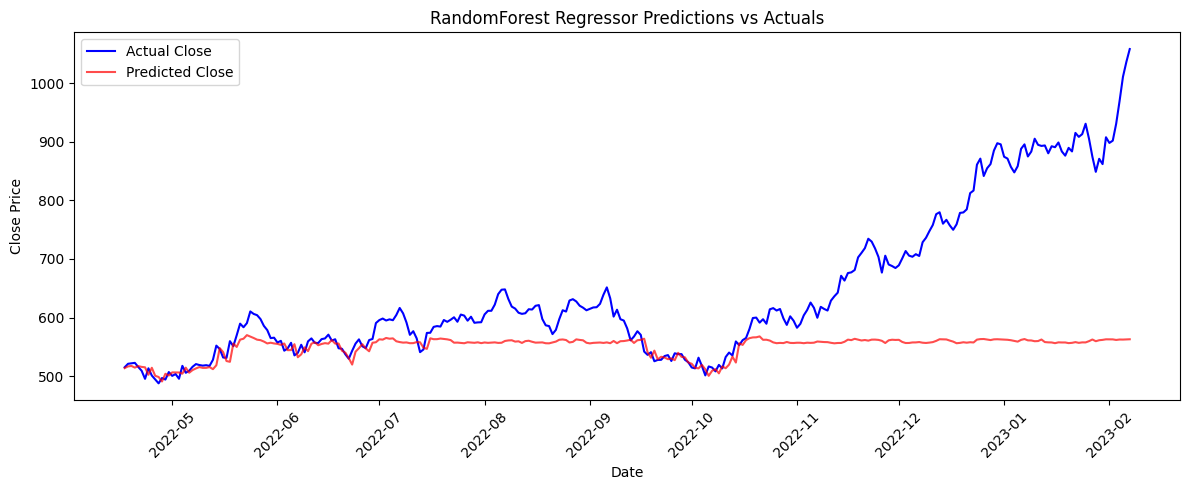

✅ Saved model to rf_close_model.pkl, scaler to scaler.pkl, artifacts to model_artifacts.pkl


In [3]:
# ==========================
# Train RandomForest and Evaluate
# ==========================
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np # <-- ADDED: Import numpy for square root

# Paths
MODEL_PATH = "rf_close_model.pkl"
SCALER_PATH = "scaler.pkl"
ARTIFACT_PATH = "model_artifacts.pkl"

# Load processed train/test
train_df = pd.read_csv("market_train.csv")
test_df = pd.read_csv("market_test.csv")

# Define features
feature_cols = [c for c in train_df.columns if c not in ["date", "target_close"]]
print("Features used:", feature_cols)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
y_train = train_df["target_close"].values
X_test = scaler.transform(test_df[feature_cols])
y_test = test_df["target_close"].values

# Train model
model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

# --- CORRECTED LINES FOR RMSE CALCULATION ---
# 1. Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, preds) 
# 2. Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse) 
# --- END CORRECTION ---

r2 = r2_score(y_test, preds)
print(f"Test MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# ==========================
# Plot Predictions vs Actuals
# ==========================
plt.figure(figsize=(12,5))
# The 'date' column contains strings and needs to be converted to datetime objects for proper plotting.
# This assumes 'date' is a column in test_df.
dates = pd.to_datetime(test_df["date"])
plt.plot(dates, y_test, label="Actual Close", color="blue")
plt.plot(dates, preds, label="Predicted Close", color="red", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("RandomForest Regressor Predictions vs Actuals")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ==========================
# Save model and artifacts
# ==========================
joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
artifacts = {
    "feature_columns": feature_cols,
    "full_raw_csv": "synthetic_market.csv",  
    "processed_features_csv": "synthetic_market_features.csv"
}
joblib.dump(artifacts, ARTIFACT_PATH)

print(f"✅ Saved model to {MODEL_PATH}, scaler to {SCALER_PATH}, artifacts to {ARTIFACT_PATH}")

Test MAE: 83.97, RMSE: 143.59, R²: -0.2725


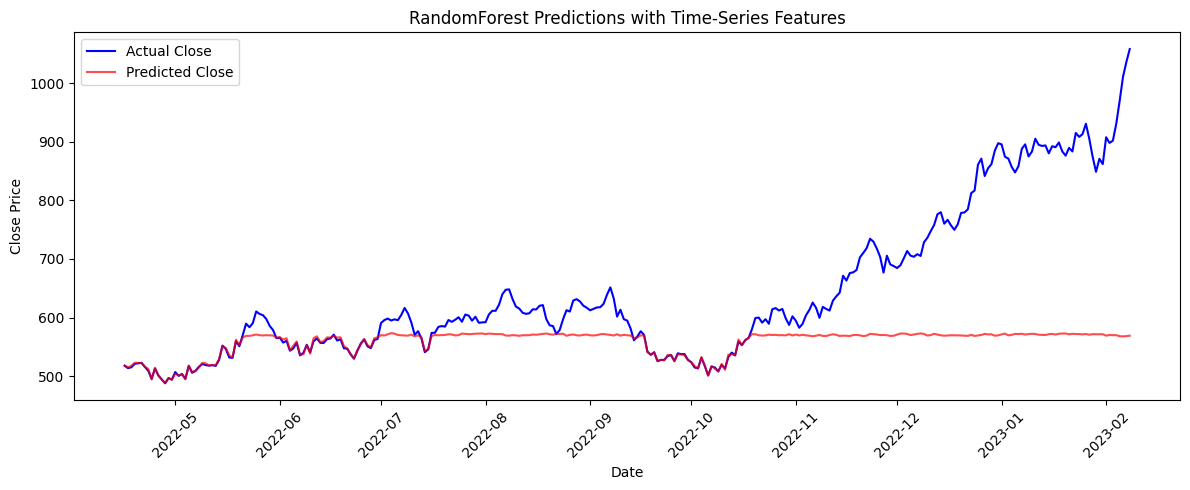

✅ Model, scaler, and artifacts saved!


In [4]:
# ==========================
# 1. Load dataset
# ==========================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Load synthetic market data
df = pd.read_csv("synthetic_market.csv", parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

# ==========================
# 2. Feature Engineering
# ==========================
def create_time_series_features(df, target="close"):
    df_feat = df.copy()
    # Lags
    for lag in range(1, 4):
        df_feat[f"lag_{lag}"] = df_feat[target].shift(lag)
    # Rolling statistics
    df_feat["roll_mean_3"] = df_feat[target].shift(1).rolling(window=3).mean()
    df_feat["roll_mean_7"] = df_feat[target].shift(1).rolling(window=7).mean()
    df_feat["roll_std_3"] = df_feat[target].shift(1).rolling(window=3).std()
    df_feat["roll_std_7"] = df_feat[target].shift(1).rolling(window=7).std()
    # Percent change
    df_feat["pct_change_1"] = df_feat[target].pct_change(1)
    df_feat["pct_change_3"] = df_feat[target].pct_change(3)
    # Volume rolling mean
    df_feat["vol_ma_3"] = df_feat["volume"].shift(1).rolling(3).mean()
    df_feat["vol_ma_7"] = df_feat["volume"].shift(1).rolling(7).mean()
    
    # Drop rows with NaN (first few rows due to lag/rolling)
    df_feat = df_feat.dropna().reset_index(drop=True)
    return df_feat

df_feat = create_time_series_features(df)

# Define features and target
target_col = "close"
feature_cols = [c for c in df_feat.columns if c not in ["date", target_col]]

X = df_feat[feature_cols]
y = df_feat[target_col]

# ==========================
# 3. Train/Test Split
# ==========================
split_idx = int(len(df_feat)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================
# 4. Train RandomForest
# ==========================
model = RandomForestRegressor(n_estimators=500, max_depth=15, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
preds = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, preds)

# --- CORRECTED LINES FOR RMSE CALCULATION ---
# Calculate MSE first, then take the square root.
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse) 
# --- END CORRECTION ---

r2 = r2_score(y_test, preds)

print(f"Test MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# ==========================
# 5. Plot Predictions vs Actual
# ==========================
plt.figure(figsize=(12,5))
plt.plot(df_feat["date"][split_idx:], y_test, label="Actual Close", color="blue")
plt.plot(df_feat["date"][split_idx:], preds, label="Predicted Close", color="red", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("RandomForest Predictions with Time-Series Features")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ==========================
# 6. Save Model & Artifacts
# ==========================
joblib.dump(model, "rf_close_model_ts.pkl")
joblib.dump(scaler, "scaler_ts.pkl")
artifacts = {
    "feature_columns": feature_cols,
    "full_raw_csv": "synthetic_market.csv"
}
joblib.dump(artifacts, "model_artifacts_ts.pkl")

print("✅ Model, scaler, and artifacts saved!")

c:\Users\hp\Desktop\share\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/step - loss: 0.0181

 8/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0230 

16/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0189

24/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0160

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0061 - val_loss: 0.0018


Epoch 2/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.8448e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6238e-04 

17/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9050e-04

25/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9677e-04

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8899e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4507e-04 - val_loss: 9.4610e-04


Epoch 3/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 8.5441e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3821e-04 

20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7091e-04

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4246e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9489e-04 - val_loss: 9.3682e-04


Epoch 4/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.1038e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4189e-04 

17/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7622e-04

26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8178e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7924e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6219e-04 - val_loss: 0.0010


Epoch 5/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.4028e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3300e-04 

21/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6662e-04

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7061e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9566e-04 - val_loss: 0.0011


Epoch 6/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.8441e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6480e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0790e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2785e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3647e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6165e-04 - val_loss: 0.0019


Epoch 7/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.7984e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7428e-04 

21/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0978e-04

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7479e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5299e-04 - val_loss: 0.0020


Epoch 8/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.6689e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7863e-04 

21/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7893e-04

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7879e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6822e-04 - val_loss: 0.0011


Epoch 9/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.2290e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9750e-04 

21/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1572e-04

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1167e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0777e-04 - val_loss: 0.0014


Epoch 10/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.4895e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6359e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5941e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6543e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7501e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1569e-04 - val_loss: 0.0028


Epoch 11/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.7545e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1153e-04 

20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5706e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3376e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1651e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4299e-04 - val_loss: 0.0027


Epoch 12/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.7286e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0138e-04 

17/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5837e-04

25/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4077e-04

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2906e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0182e-04 - val_loss: 0.0015


Epoch 13/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.9943e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6988e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4824e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3349e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2449e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8895e-04 - val_loss: 0.0012


Epoch 14/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.0899e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1061e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0802e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9834e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8778e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5177e-04 - val_loss: 0.0014


Epoch 15/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.5128e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7553e-04 

17/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9550e-04

26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2164e-04

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3905e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9723e-04 - val_loss: 0.0015


Epoch 16/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 9.9114e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7532e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0339e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6504e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4960e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7171e-04 - val_loss: 0.0016


Epoch 17/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.7993e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6948e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7550e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7419e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7490e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7049e-04 - val_loss: 0.0011


Epoch 18/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.0834e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0496e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0623e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0832e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1134e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1965e-04 - val_loss: 0.0012


Epoch 19/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.6896e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2453e-04 

20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5328e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5532e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5700e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6183e-04 - val_loss: 0.0012


Epoch 20/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.0943e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9698e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9340e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8576e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8092e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6415e-04 - val_loss: 0.0023


Epoch 21/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.7317e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5746e-04 

20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4988e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4961e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5370e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6510e-04 - val_loss: 0.0019


Epoch 22/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.1344e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8932e-04 

20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2510e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3667e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4330e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8139e-04 - val_loss: 0.0011


Epoch 23/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.5601e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1067e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2111e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1816e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1743e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0480e-04 - val_loss: 0.0029


Epoch 24/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.6091e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4560e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4009e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3256e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2928e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1924e-04 - val_loss: 0.0026


Epoch 25/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.3744e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7138e-04 

20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8099e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0412e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2243e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8938e-04 - val_loss: 0.0014


Epoch 26/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.7058e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1817e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7632e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5329e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4535e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5750e-04 - val_loss: 0.0018


Epoch 27/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.7222e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6791e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5250e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3476e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1989e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7710e-04 - val_loss: 0.0018


Epoch 28/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.5877e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5576e-04 

20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2533e-04

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0666e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6762e-04 - val_loss: 0.0014


Epoch 29/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.3473e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4749e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7778e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7580e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6764e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3753e-04 - val_loss: 0.0035


Epoch 30/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.6968e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1643e-04 

21/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7990e-04

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4686e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1392e-04 - val_loss: 0.0015


Epoch 31/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.8526e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0989e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9091e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8251e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7446e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4580e-04 - val_loss: 0.0017


Epoch 32/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.1124e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5773e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8363e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9767e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0341e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2628e-04 - val_loss: 0.0011


Epoch 33/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.7838e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3773e-04 

20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3054e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3344e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3438e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4517e-04 - val_loss: 0.0011


Epoch 34/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 2.4818e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2924e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3916e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4824e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5269e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5772e-04 - val_loss: 0.0012


Epoch 35/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.3067e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4673e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2424e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0036e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8868e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4622e-04 - val_loss: 0.0013


Epoch 36/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.6334e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3482e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1799e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0122e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9435e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7948e-04 - val_loss: 0.0023


Epoch 37/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.7115e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4567e-04 

20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3232e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3571e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3506e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3591e-04 - val_loss: 0.0024


Epoch 38/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.1300e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2724e-04 

17/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3290e-04

25/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2898e-04

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2958e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1932e-04 - val_loss: 0.0015


Epoch 39/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.0963e-05

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2998e-04 

17/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5546e-04

25/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6952e-04

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8161e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0337e-04 - val_loss: 0.0017


Epoch 40/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 2.1022e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9857e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0763e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1379e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2225e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4379e-04 - val_loss: 9.1706e-04


Epoch 41/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.3994e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2246e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9494e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8768e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8445e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7435e-04 - val_loss: 8.9244e-04


Epoch 42/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.0600e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2056e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2133e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1948e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1585e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9605e-04 - val_loss: 0.0011


Epoch 43/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.1192e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9271e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9106e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8633e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8175e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6472e-04 - val_loss: 0.0030


Epoch 44/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.4379e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7760e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6821e-04

26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7489e-04

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7933e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8976e-04 - val_loss: 0.0022


Epoch 45/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.6194e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0139e-04 

20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0192e-04

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0529e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8952e-04 - val_loss: 9.0139e-04


Epoch 46/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.8356e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0058e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0589e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0539e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0659e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0972e-04 - val_loss: 0.0011


Epoch 47/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 8.0889e-05

11/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6983e-04 

20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8168e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8102e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8076e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7957e-04 - val_loss: 0.0013


Epoch 48/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.6860e-05

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6929e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7744e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8208e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8613e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9832e-04 - val_loss: 0.0013


Epoch 49/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.4627e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6379e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3726e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2610e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2044e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9813e-04 - val_loss: 8.8134e-04


Epoch 50/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.9155e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1836e-04 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6500e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9426e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0576e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1796e-04 - val_loss: 0.0020


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


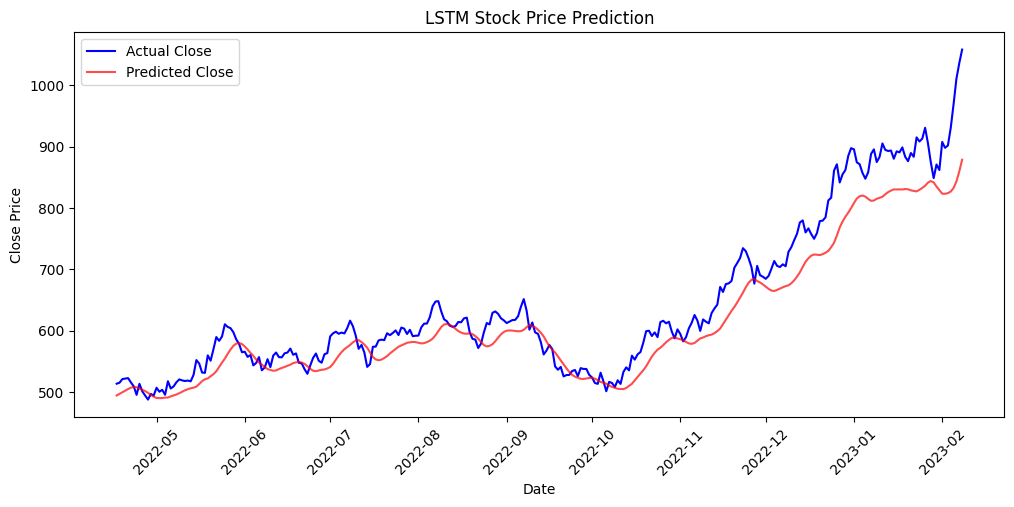

LSTM Test MAE: 32.98, RMSE: 43.62, R²: 0.8826
✅ LSTM model and scaler saved!


In [5]:
# ==========================
# 1. Load Data
# ==========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

df = pd.read_csv("synthetic_market.csv", parse_dates=["date"])


df = df.sort_values("date").reset_index(drop=True)

# Use close price (you can add volume later)
data = df[["close"]].values

# ==========================
# 2. Scale Data
# ==========================
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# ==========================
# 3. Create Sequences
# ==========================
def create_sequences(data, n_steps=10):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_steps = 10
X, y = create_sequences(data_scaled, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)

# Train/test split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ==========================
# 4. Build LSTM Model
# ==========================
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")
model.summary()

# ==========================
# 5. Train Model
# ==========================
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)

# ==========================
# 6. Predictions & Evaluation
# ==========================
y_pred = model.predict(X_test)
# Inverse scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(12,5))
plt.plot(df["date"][split_idx+n_steps:], y_test_inv, label="Actual Close", color="blue")
plt.plot(df["date"][split_idx+n_steps:], y_pred_inv, label="Predicted Close", color="red", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("LSTM Stock Price Prediction")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Compute RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM Test MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# ==========================
# 7. Save Model & Scaler
# ==========================
model.save("lstm_close_model.h5")
import joblib
joblib.dump(scaler, "lstm_scaler.pkl")
print("✅ LSTM model and scaler saved!")


        date  pred_close
0 2023-02-09  898.983154
1 2023-02-10  900.131775
2 2023-02-11  893.352356
3 2023-02-12  882.100037
4 2023-02-13  868.972595


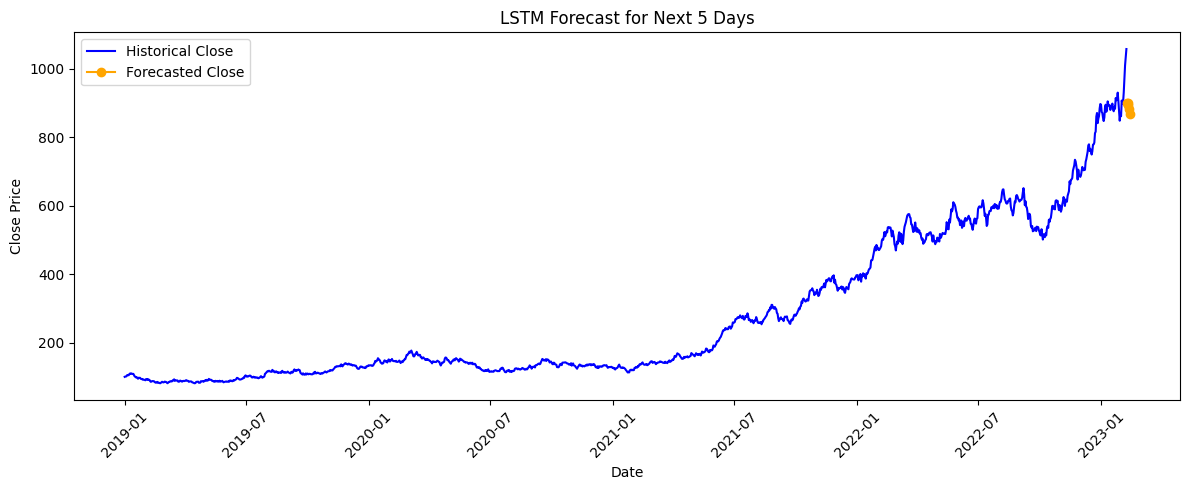

In [6]:
# ==========================
# LSTM Forecast Next n Days
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib

# --------------------------
# Load data, model, scaler
# --------------------------
df = pd.read_csv("synthetic_market.csv", parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

lstm_model = load_model("lstm_close_model.h5", compile=False)  # fix for H5 load issue
scaler = joblib.load("lstm_scaler.pkl")

# --------------------------
# Forecast function
# --------------------------
def forecast_next_days_lstm(df, n_days=5, n_steps=10):
    """
    Iteratively forecast next n_days of stock close prices using LSTM.
    
    df: DataFrame with 'close' and 'date' columns
    n_days: number of future days to forecast
    n_steps: number of past days LSTM uses for prediction
    """
    df_sorted = df.sort_values("date").reset_index(drop=True)
    close_prices = df_sorted["close"].values
    forecasted = []
    
    last_sequence = close_prices[-n_steps:]  # initial input for LSTM
    
    for day in range(1, n_days+1):
        # Scale last sequence
        seq_scaled = scaler.transform(last_sequence.reshape(-1,1)).reshape(1, n_steps, 1)
        
        # Predict next day
        pred_scaled = lstm_model.predict(seq_scaled, verbose=0)
        pred_close = scaler.inverse_transform(pred_scaled.reshape(-1,1))[0,0]
        
        # Append prediction
        last_date = df_sorted["date"].max()
        forecast_date = last_date + pd.Timedelta(days=day)
        forecasted.append({"date": forecast_date, "pred_close": pred_close})
        
        # Update sequence
        last_sequence = np.append(last_sequence[1:], pred_close)
    
    return pd.DataFrame(forecasted)

# --------------------------
# Run forecast & plot
# --------------------------
forecast_df = forecast_next_days_lstm(df, n_days=5, n_steps=10)
print(forecast_df)

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["close"], label="Historical Close", color="blue")
plt.plot(forecast_df["date"], forecast_df["pred_close"], label="Forecasted Close", color="orange", marker='o')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("LSTM Forecast for Next 5 Days")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# Cell 3: Load model and provide query functions
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity  # not used, but kept if you expand
from datetime import timedelta

MODEL_PATH = "rf_close_model.pkl"
SCALER_PATH = "scaler.pkl"
ARTIFACT_PATH = "model_artifacts.pkl"

# Load
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
artifacts = joblib.load(ARTIFACT_PATH)
feature_cols = artifacts["feature_columns"]

# Load the full raw and processed datasets
full_raw = pd.read_csv(artifacts["full_raw_csv"], parse_dates=["date"])
processed = pd.read_csv(artifacts["processed_features_csv"], parse_dates=["date"])

# Helper: create feature row given a historic df and last_date; returns df row for model
def build_feature_row(history_df, current_date):
    """
    history_df: full raw df with date, open, high, low, close, volume
    current_date: pd.Timestamp for which we will create features based on past data
    This function constructs the features matching 'feature_cols' for a row whose 'close' is known for current_date.
    """
    # we expect history_df to include current_date
    dfh = history_df.set_index("date").sort_index()
    if current_date not in dfh.index:
        raise ValueError("current_date must be present in history_df index for feature building.")
    # create a small helper series
    row = {}
    # lags: lag_1 = close at day-1 etc
    for col in feature_cols:
        if col.startswith("lag_"):
            lag = int(col.split("_")[1])
            lag_date = current_date - pd.Timedelta(days=lag)
            row[col] = dfh.at[lag_date, "close"] if lag_date in dfh.index else np.nan
        elif col.startswith("roll_mean_"):
            w = int(col.split("_")[-1])
            window_end = current_date - pd.Timedelta(days=1)
            window_start = window_end - pd.Timedelta(days=w-1)
            window = dfh.loc[window_start:window_end]["close"]
            row[col] = window.mean() if not window.empty else np.nan
        elif col.startswith("roll_std_"):
            w = int(col.split("_")[-1])
            window_end = current_date - pd.Timedelta(days=1)
            window_start = window_end - pd.Timedelta(days=w-1)
            window = dfh.loc[window_start:window_end]["close"]
            row[col] = window.std() if not window.empty else np.nan
        elif col == "pct_change_1":
            prev = current_date - pd.Timedelta(days=1)
            if prev in dfh.index and (dfh.at[prev, "close"] != 0):
                row[col] = (dfh.at[prev, "close"] - dfh.at[prev - pd.Timedelta(days=1), "close"]) / dfh.at[prev - pd.Timedelta(days=1), "close"] if (prev - pd.Timedelta(days=1)) in dfh.index else 0.0
            else:
                row[col] = 0.0
        elif col == "vol_ma_7":
            window_end = current_date - pd.Timedelta(days=1)
            window_start = window_end - pd.Timedelta(days=6)
            window = dfh.loc[window_start:window_end]["volume"]
            row[col] = window.mean() if not window.empty else dfh.at[window_end, "volume"] if window_end in dfh.index else np.nan
        else:
            # fallback: try to pull that column if exists in raw
            if col in dfh.columns:
                row[col] = dfh.at[current_date, col]
            else:
                row[col] = np.nan
    # convert to df
    feat_df = pd.DataFrame([row])
    return feat_df

# Iterative forecasting function: forecast next n days using last available day in full_raw
# ==========================
# Updated Iterative Forecast Function
# ==========================

def forecast_next_days(n=5):
    """
    Iteratively forecast next n days of close price.
    Uses the last row in full_raw as the most recent observed day.
    """
    hist = full_raw.copy().set_index("date").sort_index()
    last_date = hist.index.max()
    results = []
    history = hist.copy()

    for step in range(1, n + 1):
        target_date = last_date + pd.Timedelta(days=step)
        current_date_for_features = target_date - pd.Timedelta(days=1)

        # If current_date_for_features not in history, create synthetic row
        if current_date_for_features not in history.index:
            last_row = history.iloc[-1]
            synth = last_row.copy()
            synth.name = current_date_for_features
            # ✅ Use pd.concat instead of append
            history = pd.concat([history, pd.DataFrame([synth.values], index=[current_date_for_features], columns=history.columns)])

        # Build features referencing history
        feat_row = build_feature_row(history.reset_index().rename(columns={"index": "date"}), current_date_for_features)

        # Scale features
        X = scaler.transform(feat_row[feature_cols].ffill().bfill())
        pred_close = model.predict(X)[0]

        results.append({"date": target_date.strftime("%Y-%m-%d"), "pred_close": float(pred_close)})

        # Append predicted day to history for next iteration
        avg_vol = int(history["volume"].tail(7).mean())
        new_row = {
            "open": pred_close,
            "high": pred_close * 1.002,
            "low": pred_close * 0.998,
            "close": pred_close,
            "volume": avg_vol
        }
        # ✅ Use pd.concat instead of append
        history = pd.concat([history, pd.DataFrame([new_row], index=[target_date])])

    return pd.DataFrame(results)


# ==========================
# Updated Predict Close for Specific Date
# ==========================

def predict_date(date_str):
    """
    Predict close for a specific future date.
    If the date is beyond the last observed, extend history iteratively.
    """
    date = pd.to_datetime(date_str)
    history = full_raw.copy().set_index("date").sort_index()
    last_date = history.index.max()
    current_date = date - pd.Timedelta(days=1)

    # If current_date is beyond last observed, extend history iteratively
    if current_date > last_date:
        steps = (current_date - last_date).days
        _ = forecast_next_days(steps)  # this internally extends full_raw for next steps

        # Rebuild local history to include synthetic rows
        history = full_raw.copy().set_index("date").sort_index()
        last_date = history.index.max()
        while current_date > last_date:
            last_row = history.iloc[-1]
            synth = last_row.copy()
            synth.name = last_date + pd.Timedelta(days=1)
            history = pd.concat([history, pd.DataFrame([synth.values], index=[synth.name], columns=history.columns)])
            last_date = history.index.max()

    # Now build features safely
    feat_row = build_feature_row(history.reset_index().rename(columns={"index": "date"}), current_date)
    X = scaler.transform(feat_row[feature_cols].ffill().bfill())
    pred_close = model.predict(X)[0]

    return {"date": date_str, "pred_close": float(pred_close)}



# ==========================
# Demo Usage
# ==========================
print("Forecast next 5 days (iterative):")
print(forecast_next_days(5))

print("\nPredict close on a date (example):")
print(predict_date((full_raw['date'].max() + pd.Timedelta(days=3)).strftime("%Y-%m-%d")))


Forecast next 5 days (iterative):
         date  pred_close
0  2023-02-09  562.926244
1  2023-02-10  558.595091
2  2023-02-11  556.811892
3  2023-02-12  557.085054
4  2023-02-13  558.907910

Predict close on a date (example):


{'date': '2023-02-11', 'pred_close': 562.967276708867}
